A small side project (from this already-side-project!) to look at the lowest recorded temperatures in the area. 
I am looking at installing a high-efficiency heat pump that only works when temperatures are above -13F (-25C). 
When temperatures are lower than that, the heat pump stops working and the house would have no heat at the worst possible time. 
So the obvious question is: How often does it get below (or near) that temperature?

I suspect this information is available online somewhere, but I've got all this tooling right here, so what the heck.

In [1]:
import download_historical_data as dl
import os 
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use("default")  # alternative "ggplot"

HISTORICAL_DATA_DIR = os.path.abspath("./historical_data")
WEATHER_DATA_DIR = os.path.join(HISTORICAL_DATA_DIR, "weather_station_data")
ANALYSIS_DATA_DIR = os.path.abspath("./analysis_data/")
LOW_TEMP_DATA_DIR = os.path.join(ANALYSIS_DATA_DIR, "low_temps")

for dir in [HISTORICAL_DATA_DIR, WEATHER_DATA_DIR, LOW_TEMP_DATA_DIR, ANALYSIS_DATA_DIR]:
    if not os.path.exists(dir):
        os.makedirs(dir)


## Denver-area stations only
WEATHER_STATION_IDS = [
    "USC00053005",  # Ft Collins
    "USC00050848",  # Boulder
    "USC00055984",  # Northglenn
    "USC00058995",  # Wheat Ridge
    "USC00054762",  # Lakewood
    "USW00023062"   # Stapleton
]

In [2]:
# Uncomment to force re-download of source data
# Otherwise can also run the download script manually via: python download_historical_data.py
# Data files are saved locally so you only need to re-download to get new/different data

#dl.download_eia_historical_data(ELECTRIC_DATA_DIR, eia_respondent="PSCO")
dl.download_ghcnd_historical_data(WEATHER_DATA_DIR, WEATHER_STATION_IDS)

Finished downloading data


In [3]:
temp_df = dl.read_weather_data(WEATHER_DATA_DIR, WEATHER_STATION_IDS, earliest_date=None)
temp_df.head()

,USC00053005_tmax,USC00053005_tmin,USC00050848_tmax,USC00050848_tmin,USC00055984_tmax,USC00055984_tmin,USC00058995_tmax,USC00058995_tmin,USC00054762_tmax,USC00054762_tmin,USW00023062_tmax,USW00023062_tmin
date,,,,,,,,,,,,
1893-01-01,10.6,-10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1893-01-02,11.7,0.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1893-01-03,17.8,-5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1893-01-04,19.4,3.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1893-01-05,15.6,-5.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
for c in temp_df.columns:
    if c.endswith("_tmax"):
        temp_df.drop(c, axis="columns", inplace=True)

renames = {
    "USC00053005_tmin": "FtCollins",
    "USC00050848_tmin": "Boulder",
    "USC00055984_tmin": "Northglenn",
    "USC00058995_tmin": "WheatRidge",
    "USC00054762_tmin": "Lakewood",
    "USW00023062_tmin": "Stapleton"
}
temp_df.rename(columns=renames, inplace=True)
temp_df.head()

,FtCollins,Boulder,Northglenn,WheatRidge,Lakewood,Stapleton
date,,,,,,
1893-01-01,-10.0,NaN,NaN,NaN,NaN,NaN
1893-01-02,0.6,NaN,NaN,NaN,NaN,NaN
1893-01-03,-5.0,NaN,NaN,NaN,NaN,NaN
1893-01-04,3.9,NaN,NaN,NaN,NaN,NaN
1893-01-05,-5.6,NaN,NaN,NaN,NaN,NaN


In [6]:
stacked = temp_df.stack()
# stacked.columns.set_names(names="min_temp", inplace=True)
stacked.index.set_names(names="station", level=1, inplace=True)
stacked = pd.DataFrame(stacked)
stacked.rename(columns={0:"celsius"}, inplace=True)
stacked["fahrenheit"] = (stacked["celsius"] * 1.8) + 32
stacked.head()

,,celsius,fahrenheit
date,station,,
1893-01-01,FtCollins,-10.0,14.00
1893-01-02,FtCollins,0.6,33.08
1893-01-03,FtCollins,-5.0,23.00
1893-01-04,FtCollins,3.9,39.02
1893-01-05,FtCollins,-5.6,21.92


In [7]:
# Sort by date, latest->earliest
stacked.sort_index(axis=0, level=0, ascending=False, inplace=True)
stacked.head(10)

celsius  fahrenheit
date       station                        
2022-11-05 WheatRidge     -2.8       26.96
           Stapleton      -3.3       26.06
           Northglenn     -3.3       26.06
           Lakewood       -2.8       26.96
           FtCollins      -3.3       26.06
2022-11-04 WheatRidge     -3.3       26.06
           Stapleton      -3.3       26.06
           Northglenn     -3.9       24.98
           Lakewood       -3.3       26.06
           FtCollins      -3.3       26.06

In [8]:
sorted = stacked.sort_values(by="celsius", ascending=False, kind="stable")
sorted.head()

,,celsius,fahrenheit
date,station,,
1947-07-29,Boulder,33.9,93.02
1933-09-06,Boulder,31.7,89.06
1984-09-06,Lakewood,30.0,86.00
1934-08-01,Boulder,27.2,80.96
1922-06-22,Boulder,27.2,80.96


In [9]:
# How many days get down to our cutoff temp of -25C?
# TODO: This is actually counting station-days, not just days
very_low_days = sorted[sorted["celsius"] <= -25]
len(very_low_days)

507

In [10]:
very_low_days.head(25)

celsius  fahrenheit
date       station                        
2014-12-31 Stapleton     -25.0       -13.0
2014-02-06 Lakewood      -25.0       -13.0
           FtCollins     -25.0       -13.0
2011-02-03 Northglenn    -25.0       -13.0
2011-02-02 Northglenn    -25.0       -13.0
           FtCollins     -25.0       -13.0
2011-02-01 Lakewood      -25.0       -13.0
2009-12-10 Stapleton     -25.0       -13.0
2009-12-09 Stapleton     -25.0       -13.0
2008-12-16 Stapleton     -25.0       -13.0
2007-02-02 Northglenn    -25.0       -13.0
           Boulder       -25.0       -13.0
2006-02-19 Stapleton     -25.0       -13.0
2006-02-18 Stapleton     -25.0       -13.0
           Northglenn    -25.0       -13.0
1998-12-22 FtCollins     -25.0       -13.0
           Boulder       -25.0       -13.0
1996-02-04 Lakewood      -25.0       -13.0
1996-02-02 FtCollins     -25.0       -13.0
1990-12-29 Boulder       -25.0       -13.0
1990-12-23 Boulder       -25.0       -13.0
1989-12-21 Northglenn    -25.0       -13.0
1989-02-07 FtCollins     -25.0       -13.0
1985-02-05 Northglenn    -25.0       -13.0
1985-02-01 Stapleton     -25.0       -13.0

In [11]:
## How many days get _close_ to our cutoff?
# TODO: This is actually counting station-days, not just days
low_days = sorted[sorted["celsius"] < -20]
len(low_days)

1820

In [12]:
low_days.head(20)

celsius  fahrenheit
date       station                        
2021-02-16 Northglenn    -20.6       -5.08
2019-03-04 Boulder       -20.6       -5.08
2019-02-07 Stapleton     -20.6       -5.08
2017-01-07 FtCollins     -20.6       -5.08
2016-12-08 Stapleton     -20.6       -5.08
2014-11-14 WheatRidge    -20.6       -5.08
           Stapleton     -20.6       -5.08
2014-11-13 Northglenn    -20.6       -5.08
2014-02-08 Stapleton     -20.6       -5.08
2014-01-28 FtCollins     -20.6       -5.08
2014-01-06 WheatRidge    -20.6       -5.08
2013-12-09 FtCollins     -20.6       -5.08
2013-12-06 Northglenn    -20.6       -5.08
2013-12-05 Northglenn    -20.6       -5.08
2013-01-13 Stapleton     -20.6       -5.08
2011-12-06 Lakewood      -20.6       -5.08
           FtCollins     -20.6       -5.08
2011-02-10 Northglenn    -20.6       -5.08
2011-02-03 Boulder       -20.6       -5.08
2009-01-28 Stapleton     -20.6       -5.08

array([[<AxesSubplot: title={'center': 'celsius'}>,
        <AxesSubplot: title={'center': 'fahrenheit'}>]], dtype=object)

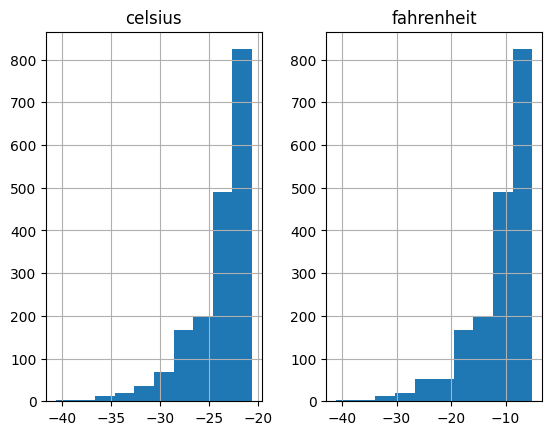

In [13]:
low_days.hist()

In [14]:
## Record-breaking coldest days
rev_sorted = stacked.sort_values(by="celsius", ascending=True, kind="stable")
rev_sorted.head(25)

,,celsius,fahrenheit
date,station,,
1951-02-01,FtCollins,-40.6,-41.08
1930-01-17,FtCollins,-38.9,-38.02
1899-02-12,FtCollins,-38.9,-38.02
1899-02-06,FtCollins,-38.9,-38.02
1919-12-09,FtCollins,-37.2,-34.96
1987-04-04,Northglenn,-36.7,-34.06
1930-01-17,Boulder,-36.1,-32.98
1986-11-15,Northglenn,-35.6,-32.08
1962-01-10,FtCollins,-35.6,-32.08
